In [1]:
import ray
GPU_UTILIZATION = 0.0
ray.init(num_gpus=GPU_UTILIZATION)

2023-11-19 21:00:11,744	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-19 21:00:13,586	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.13
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8266


In [3]:
from ray import train, tune
from ray.rllib.algorithms.ppo import PPO
from ray.tune.schedulers import PopulationBasedTraining

GPU_UTILIZATION = 0.0

pbt = PopulationBasedTraining(
    time_attr="time_total_s",
    perturbation_interval=120,
    resample_probability=0.25,
    # Specifies the mutations of these hyperparams
    hyperparam_mutations={
        "lambda": lambda: random.uniform(0.9, 1.0),
        "clip_param": lambda: random.uniform(0.01, 0.5),
        "lr": [1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
        "num_sgd_iter": lambda: random.randint(1, 2),
        "sgd_minibatch_size": lambda: random.randint(128, 16384),
        "train_batch_size": lambda: random.randint(2000, 160000),
    }
)

In [4]:
tuner = tune.Tuner(
    PPO,
    run_config=train.RunConfig(
        name="pbt_cart_pole",
    ),
    tune_config=tune.TuneConfig(
        scheduler=pbt,
        num_samples=8,
        metric="episode_reward_mean",
        mode="max",
    ),
    param_space={
        "env": "CartPole-v1",
        "kl_coeff": 1.0,
        "num_workers": 8,
        "num_gpus": GPU_UTILIZATION,
        # These params are tuned from a fixed starting value.
        "lambda": 0.95,
        "clip_param": 0.2,
        "lr": 1e-4,
        # These params start off randomly drawn from a set.
        "num_sgd_iter": tune.choice([2,]),
        "sgd_minibatch_size": tune.choice([64, 128, 256]),
        "train_batch_size": tune.choice([320, 540, 1024]),
    },
)
results = tuner.fit()

(pid=158376) 2023-11-19 21:12:42,032	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(PPO pid=158376) No CUDA runtime is found, using CUDA_HOME='/home/przemek/miniconda3/envs/ray_projects'
(PPO pid=158376) /home/przemek/miniconda3/envs/ray_projects/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:114: UserWarning: WARNING: failed to get cudart_version from onnxruntime build info.
(PPO pid=158376)   warnings.warn("WARNING: failed to get cudart_version from onnxruntime build info.")
(PPO pid=158376) In

In [15]:
chck = results.get_best_result().get_best_checkpoint("episode_len_mean","max")

In [35]:
import os 
os.listdir(chck.path+'/policies/default_policy')

['policy_state.pkl', 'rllib_checkpoint.json']

In [36]:
from ray.rllib.algorithms.algorithm import Algorithm
algo2 = Algorithm.from_checkpoint(chck)

/home/przemek/miniconda3/envs/ray_projects/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/przemek/miniconda3/envs/ray_projects/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/przemek/miniconda3/envs/ray_projects/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprec

In [44]:
import gymnasium as gym 
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [45]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
model = algo2.get_policy().model

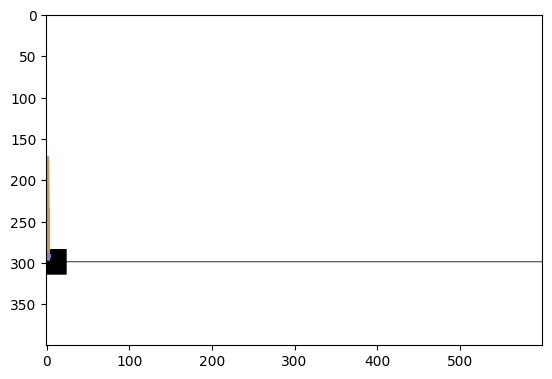

Episode finished after 273 steps


In [49]:
next_state = env.reset()[0]
num_steps = 1000

for step in range(num_steps):
    with torch.no_grad():
        action = model({'obs': torch.Tensor(next_state.reshape([1,4]))})['action_dist_inputs'].argmax().item()

    next_state, reward, done = env.step(action)[:3]

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    print(step, end='\r')
    
    if done:
        print(f"Episode finished after {step+1} steps")
        break

In [56]:
sum([i.numel() for i in model.encoder.actor_encoder.parameters()])

67072

In [55]:
model

PPOTorchRLModule(
  (encoder): TorchActorCriticEncoder(
    (actor_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): Tanh()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Tanh()
        )
      )
    )
    (critic_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): Tanh()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Tanh()
        )
      )
    )
  )
  (pi): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
  (vf): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)